<a href="https://colab.research.google.com/github/tomcotter7/OpenAI-GeneticAlgorithms/blob/main/neuroevolution_robotics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Imports

In [5]:
#Include this at the top of your colab code
import os
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc 
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc
  # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco-py<2.2,>=2.1'
  # run once
  !touch .mujoco_setup_complete

try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin:/usr/lib/nvidia'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin:/usr/lib/nvidia'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  import mujoco_py

In [6]:
!pip install stable-baselines3[extra]

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout
import random
import numpy as np
import gym
import matplotlib.pyplot as plt
from stable_baselines3.common.atari_wrappers import *
import math

# Agent Class

In [8]:
class Agent:

    def __init__(self, name):

        self.nn = self.build_model()
        self.name = name

    def build_model(self):

        model = tf.keras.Sequential()
        model.add(Conv2D(32, [8,8], strides=(4,4), activation="relu", input_shape=(84,84,1)))
        model.add(Conv2D(64, [4,4], strides=(4,4), activation="relu"))
        model.add(Flatten())
        model.add(Dense(256,activation="relu"))
        model.add(Dropout(0.1))
        model.add(Dense(6))
        return model

    def update_weights(self, new_weights):
        for index, layer in enumerate(self.nn.layers):
            layer.set_weights(new_weights[index])

    def get_weights(self):
        return [layer.get_weights() for layer in self.nn.layers]
    
    
  


# Runner Class

In [81]:
class Runner:

  def __init__(self, env, generations, experiences_per_gen=8, pop_size=10, initial_gen=None):
    self.env = WarpFrame(env, 84)
    if initial_gen == None:
      self.gen = self.create_initial_gen(pop_size)
    else:
      self.gen = initial_gen
    self.generations = generations
    self.experience = experiences_per_gen

  # function to create an initial generation
  def create_initial_gen(self, n):
    return [Agent("agent"+str(i)) for i in range(n)]
  

  # function to run a generation across an environment
  def run_gen_env(self, gen):
    results = []
    for agent in gen:
        nn_specific_results = [self.run_env(self.env, agent.nn) for i in range(self.experience)]
        print("Agent {} with scores {}".format(agent.name, nn_specific_results))
        results.append((agent.name, 0.3 * np.median(nn_specific_results, axis=0) + 0.7 * np.mean(nn_specific_results, axis=0)))
    print("Results {}".format(results))
    return gen, results
   

  # function to run an agent in an environment
  def run_env(self, env, nn, nolimit=False):
    obs = env.reset()
    reward = -1
    award = 0
    done = False
    while not done:
        action = nn.predict(np.array([obs]))
        action = np.argmax(action, axis=1)
        obs, reward, done, info = env.step(action[0])
        if info['episode_frame_number'] >= 10000:
        if not nolimit and info['lives'] < 3:
          break
        award += reward

    if nolimit:
      print("one time")

    return award
  
  # crossover functions
  def crossover_lwb(self, wbs1, wbs2, cr):
    for j in range(len(wbs1)):
      chance = random.uniform(0,1)
      if chance < cr:
        temp = wbs1[j].copy()
        wbs1[j] = wbs2[j]
        wbs2[j] = temp

    return wbs1, wbs2    

  def crossover(self, weights1, weights2, cr):
    new_weights1 = []
    new_weights2 = []
    for i in range(len(weights1)):
      if weights1[i] != []:
        lw1, lw2 = self.crossover_lwb(weights1[i][0], weights2[i][0], cr)
        lb1, lb2 = self.crossover_lwb(weights1[i][1], weights2[i][1], cr)
        new_weights1.append([lw1, lb1])
        new_weights2.append([lw2, lb2])
      else:
        new_weights1.append([])
        new_weights2.append([])
    return new_weights1, new_weights2

  

  def mutate_wb(self, lw, mr):
    chance = random.uniform(0, 1)
    if chance < mr:
      lw = np.vectorize(lambda x: np.multiply(x, random.uniform(0.5, 1.5)))(lw)
    return lw

  def mutate_lw(self, lw, mr):
    return [self.mutate_wb(wb, mr) for wb in lw]

  def mutate(self, weights, mr):
    return [self.mutate_lw(lw, mr) for lw in weights]
  
  def just_mutation(self, agent, mr):
    agent.update_weights(self.mutate(agent.get_weights(), mr))
    return agent


  def run_evolution(self, agent1, agent2):
    cweights1, cweights2 = self.crossover(agent1.get_weights(), agent2.get_weights())

    mweights1 = self.mutate(cweights1)
    mweights2 = self.mutate(cweights2)

    agent1.update_weights(mweights1)
    agent2.update_weights(mweights2)

    return agent1, agent2

  def get_best_n_names(self, lst, n=2):
    best_n_names = [name for name, _, in sorted(lst, key=lambda x: x[1])[-n:]]
    return best_n_names


  def get_new_gen(self, gen_reward, g):

    new_gen = []

    mr = 0.3 / math.sqrt(g + 1)
    cr = 0.3

    # initially let's perform elitism and select the best 2 individuals.
    best_2_names = self.get_best_n_names(gen_reward)
    print("2 best agents from generation:", best_2_names)
    best_agents = [self.just_mutation(indiv, mr=0.01) for indiv in self.gen if indiv.name in best_2_names]
    new_gen.append(best_agents[0])
    new_gen.append(best_agents[1])

    # now let's perform tournament selection n times

    for i in range(int(len(self.gen) / 2) - 1):
        tournament_1 = random.sample(gen_reward, int(len(gen_reward) / 2))
        # take the two best parents from this tournament.
        best_2 = self.get_best_n_names(tournament_1)
        agents = [indiv for indiv in self.gen if indiv.name in best_2]
        # perform crossover
        c1, c2 = self.run_evolution(agents[0], agents[1], cr, mr)
        new_gen.append(c1)
        new_gen.append(c2)
      
    print(new_gen)
    
    for i in range(len(new_gen)):
      agent = new_gen[i]
      agent.name = "agent%i" % (i)
      

    self.gen = new_gen

  def best_score(self, gen_reward):
    best_score = [score for _, score in sorted(gen_reward, key=lambda x: x[1])][-1]
    return best_score
  

  def run_genetic_algorithm(self):
    best_scores = []
    mean_scores = []
    median_scores = []
    self.gen, gen_reward = self.run_gen_env(self.gen)
    for g in range(self.generations):
      print("Generation %i" % (g))
      best_scores.append(self.best_score(gen_reward))
      mean_scores.append(np.mean([score for _, score in gen_reward]))
      median_scores.append(np.median([score for _, score in gen_reward]))
      print("Scores:", gen_reward)
      gen = self.get_new_gen(gen_reward, g)
      self.gen, gen_reward = self.run_gen_env(self.gen)
    
    return self.gen, gen_reward, best_scores, mean_scores, median_scores
  

  def run_multiple_times(self, model=None, random=False):
    if random:
      return [self.run_random_algorithm(self.env) for i in range(self.experience)]
    else:
      return [self.run_env(self.env, model) for i in range(self.experience)]

  def run_random_algorithm(self, env):
    obs = env.reset()
    award = 0
    done = False
    while not done:
      action = env.action_space.sample()
      obs, reward, done, info = env.step(action)
      award += reward

    return award

  





# Main

Agent agent0 with scores [105.0, 75.0]
Agent agent1 with scores [60.0, 60.0]
Results [('agent0', 90.0), ('agent1', 60.0)]
Generation 0
Scores: [('agent0', 90.0), ('agent1', 60.0)]
2 best agents from generation: ['agent1', 'agent0']
[<__main__.Agent object at 0x7f907b684050>, <__main__.Agent object at 0x7f900066d4d0>]
Agent agent0 with scores [105.0, 105.0]
Agent agent1 with scores [75.0, 5.0]
Results [('agent0', 105.0), ('agent1', 40.0)]
Generation 1
Scores: [('agent0', 105.0), ('agent1', 40.0)]
2 best agents from generation: ['agent1', 'agent0']
[<__main__.Agent object at 0x7f907b684050>, <__main__.Agent object at 0x7f900066d4d0>]
Agent agent0 with scores [105.0, 105.0]
Agent agent1 with scores [140.0, 45.0]
Results [('agent0', 105.0), ('agent1', 92.5)]


KeyboardInterrupt: ignored

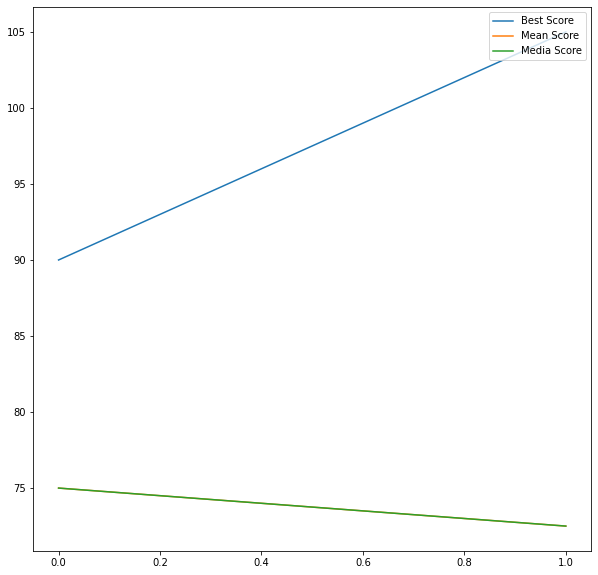

In [82]:
ENV = gym.make("SpaceInvaders-v4")

sp_runner = Runner(ENV, 2, experiences_per_gen=2, pop_size=2)
gen, gen_reward, best_scores, mean_scores, median_scores = sp_runner.run_genetic_algorithm()

plt.figure(figsize=(10,10))
plt.plot(best_scores, label="Best Score")
plt.plot(mean_scores, label="Mean Score")
plt.plot(median_scores, label="Media Score")
plt.legend(loc="upper right")

NEW_ENV = gym.make("DemonAttack-v4")

final_best_agent_name = max(gen_reward, key=lambda x: x[1])[0]
best_agent = [agent for agent in gen if agent.name == final_best_agent_name][0]
da_runner = Runner(NEW_ENV, 10, experiences_per_gen=2, pop_size=2)

random_results = da_runner.run_multiple_times(random=True)
model_results = da_runner.run_multiple_times(model=best_agent.nn)

print("Random Results: Mean: {}, Best: {}".format(np.mean(random_results), max(random_results)))
print("Model Results: Mean: {}, Best: {}".format(np.mean(model_results), max(model_results)))
